## Guidelines

Le prime celle qui in basso, in [questa](http://localhost:8888/notebooks/charts.ipynb#Setting-Up) sezione, hanno lo scopo di scaricare e installare i pacchetti (se non già presenti) e di importare moduli e file csv.


Nel blocco di codice in cui si stampa ogni grafico, ci saranno commentate le label e le intestazioni, perché il grafico viene esportato in `.svg` nella cartella `/charts/` e viene aggiunto in una fase successiva, durante la creazione della presentazione.

## Setting Up

In [2]:
import sys  
!{sys.executable} -m pip install urllib2

ERROR: Could not find a version that satisfies the requirement urllib2 (from versions: none)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
ERROR: No matching distribution found for urllib2


In [1]:
columns_mapping = {"Gioco": "name", "Genere": "genre", "Produzione*": "production", "Origine": "from_where", "prezzo(€)": "price_in_euro", "Vendite stimate(k)": "sales_k", "max giocatori": "max_players", "recensioni positive(%)": "reviews"}

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify

In [15]:
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
import matplotlib.font_manager as fm

url = 'https://github.com/google/fonts/blob/main/ofl/lato/Lato-Regular.ttf?raw=true'

response = urlopen(url)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()

fm.fontManager.addfont(f.name)
prop = fm.FontProperties(fname=f.name)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

plt.rcParams["svg.fonttype"] = 'none'

In [4]:
def fillempty_floats(df, columns):
    for column in columns:
        df[column] = df[column].replace('', 0)
        df[column] = df[column].astype('float32')
    return df

def build_chart_path(name):
    return f"charts/{name}.svg"

In [5]:
games = pd.read_csv("data/2024-games.csv", na_filter=False)
games.drop(columns=["Unnamed: 8", "note"], inplace=True)
games.rename(columns=columns_mapping, inplace=True)
games = fillempty_floats(games, ["price_in_euro", "sales_k", "max_players", "reviews"])

In [6]:
sales_aaa_aa = games.query('production == "AA" or production == "AAA"')

## Stima vendite AAA 2024

In [7]:
max_cap = 5000

def cap_values(value, max_cap):
    return min(value, max_cap) if value > max_cap else value

In [8]:
sales_aaa = sales_aaa_aa.query('production == "AAA" and sales_k > 0')
sales_aaa['capped_sales'] = sales_aaa.apply(lambda x: cap_values(x['sales_k'], max_cap), axis=1)

sales_aaa

/var/folders/38/f7xqds1j4yx06zmz7ht8r3c40000gn/T/ipykernel_95156/2155849701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_aaa['capped_sales'] = sales_aaa.apply(lambda x: cap_values(x['sales_k'], max_cap), axis=1)


,name,Genere (principale),production,from_where,price_in_euro,sales_k,max_players,reviews,capped_sales
10,Call of Duty: Black Ops 6,PVP shooter,AAA,America,80.0,15552.0,315334.0,57.0,5000.0
11,Concord,PVP shooter,AAA,America,40.0,16.0,697.0,66.0,16.0
12,Dragon Age: The Veilguard,role-playing game,AAA,America,60.0,946.0,89418.0,70.0,946.0
13,Black Myth: Wukong,action-adventure,AAA,Cina,60.0,29922.0,2415714.0,96.0,5000.0
14,Star Wars Outlaws,action-adventure,AAA,Europa,70.0,28.0,2492.0,67.0,28.0
15,Silent Hill 2,horror,AAA,Europa,70.0,475.0,23676.0,93.0,475.0
16,Skull and Bones,MMO,AAA,Europa,60.0,35.0,2615.0,65.0,35.0
17,Suicide Squad: Kill the Justice League,PVE shooter,AAA,Europa,70.0,250.0,13459.0,67.0,250.0
18,S.T.A.L.K.E.R 2: Hearth of Chornobyl,shooter,AAA,Europa,60.0,1133.0,121335.0,78.0,1133.0
19,Dragon Ball: Sparkling! Zero,fighting,AAA,Giappone,70.0,1462.0,122554.0,89.0,1462.0


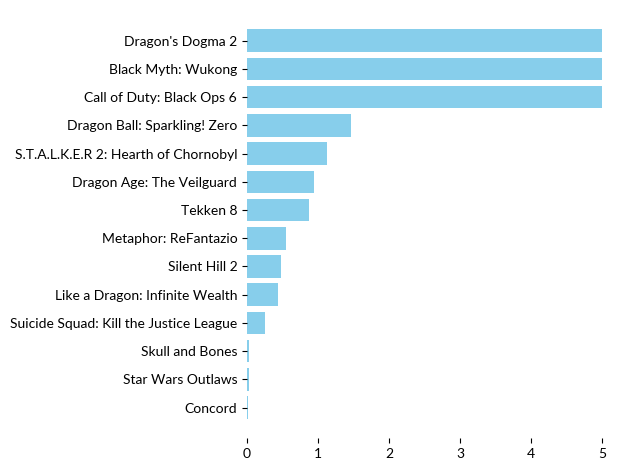

In [16]:
sales_aaa = sales_aaa.sort_values(by=['capped_sales'])
plt.barh(sales_aaa['name'], sales_aaa['capped_sales']/1000, color='skyblue')

for spine in plt.gca().spines.values(): spine.set_visible(False)

# plt.title('Stima vendite delle major releases del 2024')
# plt.xlabel('MILIONI di copie vendute')
# plt.ylabel('')

plt.tight_layout()

# plt.show()
plt.savefig(build_chart_path("sales_aaa_2024"), format="svg")

#### Note:
aggiungere a mano un + dopo il 5000 della scala;
segnare a mano le vendite degli ultimi 3: 35, 28, 16
marcare i primi 4 di colore diverso per far capire che superano la scala

##### Problema:
in entrambi i grafici è difficile contare il numero di vendite.
##### Suggerimento:
aggiungere linee verticali sugli assi

## Vendite giochi per continente di origine

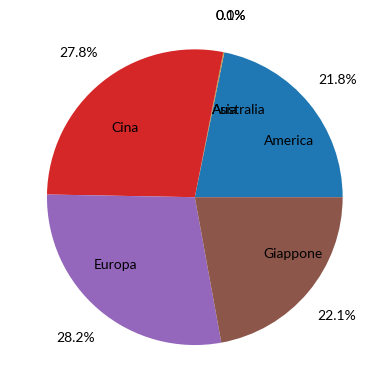

In [22]:
agg_by_continent = games.groupby(['from_where'])['sales_k'].sum().to_frame().reset_index()

# agg_by_continent

fig, ax = plt.subplots()
ax.pie(agg_by_continent['sales_k'], labels=agg_by_continent['from_where'], autopct='%1.1f%%', pctdistance=1.25, labeldistance=.6)

plt.savefig(build_chart_path("sales_by_continent_2024"), format="svg")

#### Note

Sarebbe meglio raggruppare Singapore+Giappone+Corea in Asia? Magari creiamo due label distinte:

1. Cina
2. Asia (senza Cina)

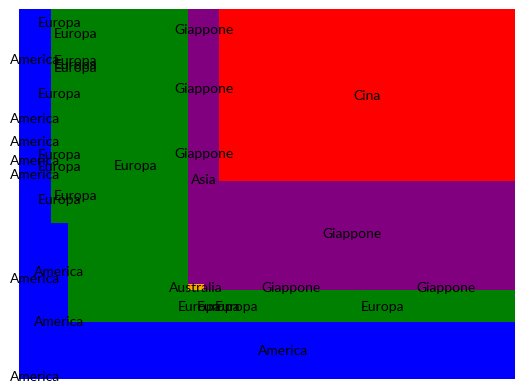

In [23]:
country_map = {
    "America": "blue",
    "Cina": "red",
    "Europa": "green",
    "Giappone": "purple",
    "Asia": "purple",
    "Corea": "purple",
    "Australia": "orange"
}

games['color'] = games['from_where'].apply(lambda x: country_map[x])
ordered = games.sort_values(by=['color'])

squarify.plot(sizes=ordered['sales_k'], label=ordered['from_where'], color=ordered['color'])
plt.axis("off")

plt.savefig(build_chart_path("treemap_sales_by_continent"), format="svg")

#### Note

Tralasciando i colori che sono pessimi e vanno cambiati (è giusto per dare l'idea), non sono sicuro possa andar bene come grafico. 
In questo caso magari non sono tutti uniti quindi è ancora più confusionario, ma magari meglio un area plot?

## Vendite in relazione alle recensioni

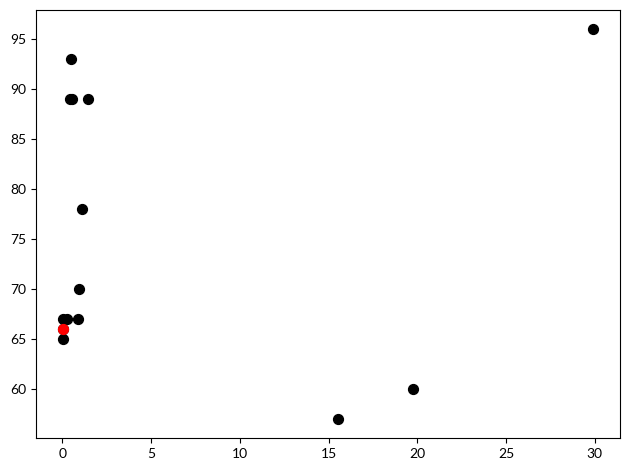

In [24]:
import matplotlib.pyplot as plt

concord = sales_aaa.query('name=="Concord"')

plt.scatter(sales_aaa['sales_k']/1000, sales_aaa['reviews'], color='black', marker='o', s=50)
plt.scatter(concord['sales_k']/1000, concord['reviews'], color='Red', marker='o', s=50)

# plt.title('Vendite in relazione alle recensioni')
# plt.xlabel('Milioni di copie vendute')
# plt.ylabel('Positività delle recensioni')

plt.tight_layout() 

plt.savefig(build_chart_path("sales_and_reviews_2024"), format="svg")

## Giochi Steam approvati in Cina

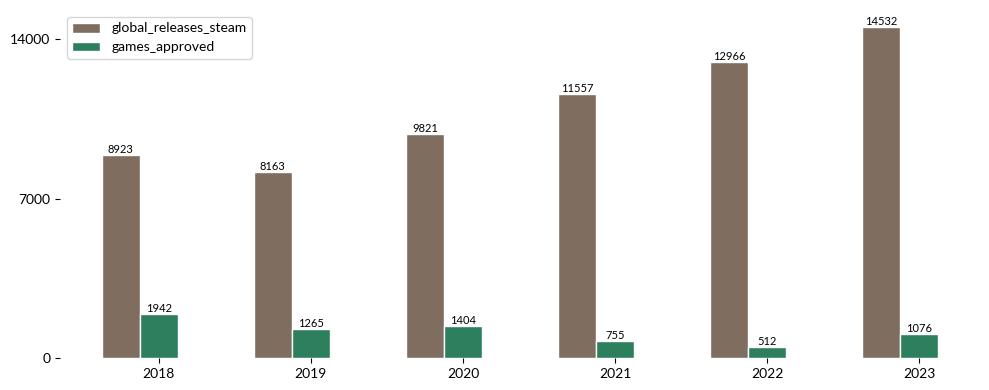

In [110]:
import numpy as np

games_in_china = pd.DataFrame(
    index=list(range(2018, 2024)),
    data={
    'global_releases_steam': [8923, 8163, 9821, 11557, 12966, 14532],
    'domestic_games_approved': [1892, 1085, 1307, 679, 468, 0],
    'games_approved': [50, 180, 97, 76, 44, 1076]
    }
)

# Merging data about local games and non-local games in China that are approved
games_in_china['games_approved'] =  games_in_china.iloc[:, 1:3].sum(axis=1)

barWidth = 0.25

r = np.arange(len(games_in_china.index))
r2 = r + barWidth

fig, ax = plt.subplots(figsize=(10, 4))
bars1= ax.bar(r, games_in_china['global_releases_steam'], color='#7f6d5f', width=barWidth, edgecolor='white', label='global_releases_steam')
bars2= ax.bar(r2, games_in_china['games_approved'], color='#2d7f5e', width=barWidth, edgecolor='white', label='games_approved')

# Xticks
ax.set_xticks(r + barWidth)
ax.set_xticklabels(games_in_china.index)
ax.set_yticks(list(range(0, 15000, 7000)))

for bar_group in [bars1, bars2]:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height}',
            ha='center', va='bottom',
            fontsize=8
        )

for spine in plt.gca().spines.values(): spine.set_visible(False)

plt.tight_layout()

ax.legend()
plt.show()

#### Note

Rimuovere scala sull'asse delle y. Abbiamo già i numeri sulle colonne